In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter

c:\Python311\Lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [6]:
qt.basis(2, 0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

# Doppler (Sideband) Cooling:

In [18]:
def compute_ss(n_motional,nu,Delta,Gamma,eta):

    # Convention: |g⟩⟨g| and |e⟩⟨e| for ground and excited states
    ground_proj = qt.basis(2, 0).proj()
    excited_proj = qt.basis(2, 1).proj()

    # dipole lowering and raising operators:
    D = qt.sigmap()       # |g⟩⟨e|
    D_dag = qt.sigmam()   # |e⟩⟨g|

    # motional state operators
    a = qt.destroy(n_motional)     # Annihilation operator
    a_dag = qt.create(n_motional)  # Creation operator

    # Position operator x 
    x = (a + a_dag) # I've eaten up the units bc I only use eta later anyway

    # Identity operators for tensor products
    id_internal = qt.qeye(2)
    id_motional = qt.qeye(n_motional)

    # Define e^(±ikx) operators using the position operator
    # We use the exponential series expansion
    def exp_ikx(eta,x):
        exp_x = (1j * eta * x).expm()
        return exp_x

    Omega = 0.05*Gamma
    # Hamiltonian composition
    H_motional = nu * qt.tensor(id_internal, a_dag * a)
    H_atomic = Delta * qt.tensor(excited_proj, id_motional)
    H_interaction = -Omega/2 * (qt.tensor(D_dag, exp_ikx(eta,x)) + 
                            qt.tensor(D, exp_ikx(-eta,x)))  # h.c. term  

    #Note that we follow a convention - the order is always atomic tensor motional


    # total Hamiltonian
    H_total = H_motional + H_atomic + H_interaction

    # collapse operators for emission in positive and negative x-direction (1D)
    L_plus = np.sqrt(0.5*Gamma) * qt.tensor(D,  exp_ikx(eta,x))
    L_minus = np.sqrt(0.5*Gamma) * qt.tensor(D, exp_ikx(-eta,x))
    c_ops = [L_plus, L_minus]


    '''
    Rather than using MESolver we try using SSSolver (only interested in long-term behavior of system) - as done in the paper. 

    Get steady state values of the system as a function of diff parameters. 
    '''


    rho_ss = qt.steadystate(H_total, c_ops)

    # Measurement operators
    measure_excited = qt.tensor(excited_proj, id_motional)
    measure_ground = qt.tensor(ground_proj, id_motional)
    measure_n = qt.tensor(id_internal, a_dag * a)

    # Compute steady-state expectation values
    excited_pop_ss = qt.expect(measure_excited, rho_ss)
    ground_pop_ss = qt.expect(measure_ground, rho_ss)
    motional_n_ss = qt.expect(measure_n, rho_ss)


    return ground_pop_ss, excited_pop_ss, motional_n_ss

### Generating the plots for a range of parameters:

In [3]:
# example system parameters based on physical grounds
n_motional = 10         # Number of motional levels
Gamma = 1e6 # Spontaneous emission rate (Γ) in Hz
Delta = 0.5 * Gamma  # Detuning (Δ) in Hz
nu = 0.5 * Gamma# Trap frequency (ν) in Hz 

eta = 0.05              #Lamb-dicke parameter
# Eta removes the necessity for defining k because already given

ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,Delta,Gamma,eta)


print("Steady-state excited population:", excited_pop_ss)
print("Steady-state ground population:", ground_pop_ss)
print("Steady-state average phonon number:", motional_n_ss)

# for our upcoming plots, we can take freedom in varying nu, Delta for a given Gamma (of 0.01 MHz)

Steady-state excited population: 0.0004987633390143187
Steady-state ground population: 0.9995012366609856
Steady-state average phonon number: 2.203360500985979


### Unresolved Sideband Regime:

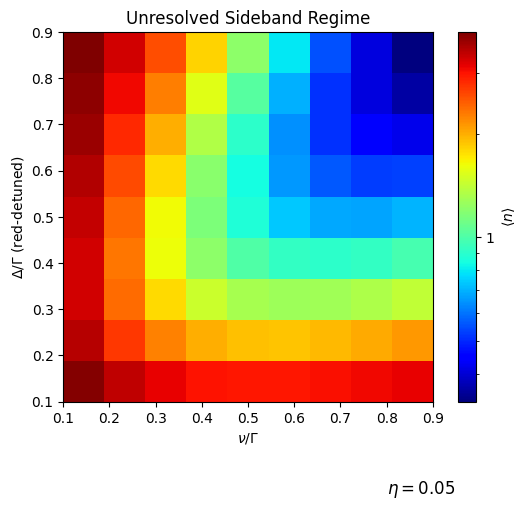

In [19]:
n_motional = 10        # Number of motional levels
Gamma = 1             # Spontaneous emission rate (Γ) in Hz
eta = 0.05              #Lamb-dicke parameter

nu_values = np.arange(0, 1*Gamma, 0.1*Gamma)[1:]
Delta_values = np.arange(0, 1*Gamma, 0.1*Gamma)[1:]
avg_n = np.zeros((len(nu_values), len(Delta_values)))

for i, nu in enumerate(nu_values):  
    for j, Delta in enumerate(Delta_values):  
        ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,Delta,Gamma,eta)
        avg_n[i, j] = motional_n_ss  


##Plotting code below

fig, ax = plt.subplots()
im = ax.imshow(avg_n, 
               extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
                       Delta_values[0] / Gamma,Delta_values[-1] / Gamma], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(avg_n[avg_n > 0]), vmax=np.max(avg_n)), 
               cmap="jet")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta / \Gamma$ (red-detuned)')
ax.set_title("Unresolved Sideband Regime")

# Text labels
# ax.text(0.3, -0.9, r'$\nu < \Gamma$', fontsize=14, color='black')
ax.text(0.8, -0.1, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

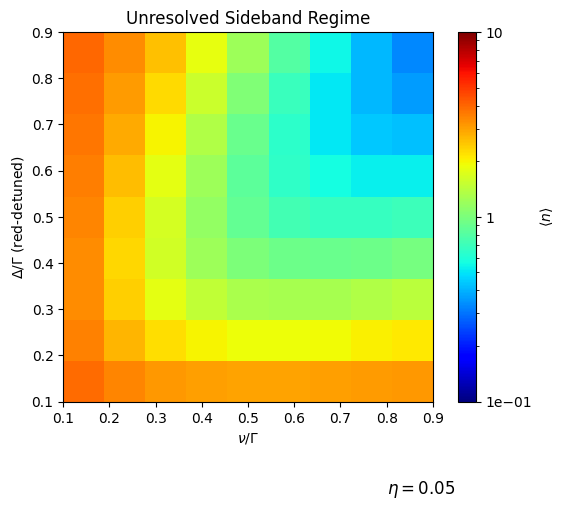

In [20]:
##Plotting code below

fig, ax = plt.subplots()
im = ax.imshow(avg_n, 
               extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
                       Delta_values[0] / Gamma,Delta_values[-1] / Gamma], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(1e-1), vmax=10), 
               cmap="jet")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta / \Gamma$ (red-detuned)')
ax.set_title("Unresolved Sideband Regime")

# Text labels
# ax.text(0.3, -0.9, r'$\nu < \Gamma$', fontsize=14, color='black')
ax.text(0.8, -0.1, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

### Resolved Sideband Regime:

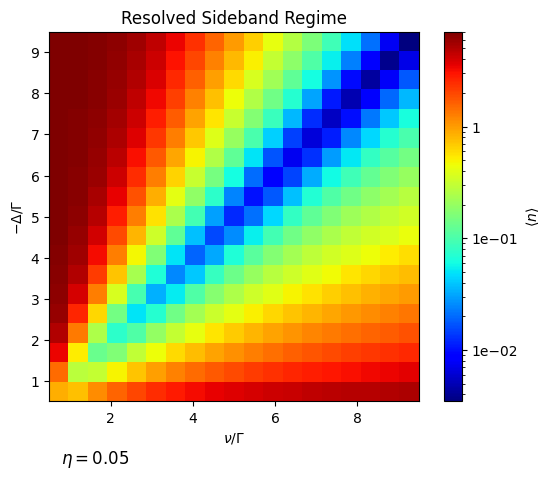

In [23]:
n_motional = 15         # Number of motional levels
Gamma = 1           # Spontaneous emission rate (Γ) in Hz
eta = 0.05              #Lamb-dicke parameter

nu_values = np.arange(0, 10*Gamma, 0.5*Gamma)[1:]
Delta_values = np.arange(0, 10*Gamma, 0.5*Gamma)[1:]

avg_n_resolved = np.zeros((len(nu_values), len(Delta_values)))

for i, nu in enumerate(nu_values):  
    for j, Delta in enumerate(Delta_values):  
        ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,Delta,Gamma,eta)
        avg_n_resolved[i, j] = motional_n_ss  

fig, ax = plt.subplots()
im = ax.imshow(avg_n_resolved, 
               extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
                       Delta_values[0] / Gamma,Delta_values[-1] / Gamma], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(avg_n_resolved[avg_n_resolved > 0]), vmax=np.max(avg_n_resolved)), 
               cmap="jet")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$-\Delta / \Gamma$')
ax.set_title("Resolved Sideband Regime")

# Text labels
# ax.text(0.3, -0.9, r'$\nu > \Gamma$', fontsize=14, color='black')
ax.text(0.8, -1, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

# plt.imshow(avg_n, extent=[nu_values[0], nu_values[-1], abs(Delta_values[0]), abs(Delta_values[-1])])
# plt.colorbar()
# plt.xlabel(r'$\nu / \gamma$')  # x-axis label
# plt.ylabel(r'$-\Delta / \gamma$')  # y-axis label
# plt.show()


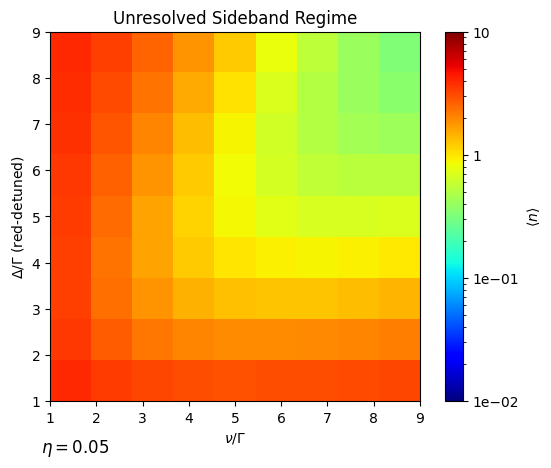

In [22]:
##Plotting code below

fig, ax = plt.subplots()
im = ax.imshow(avg_n, 
               extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
                       Delta_values[0] / Gamma,Delta_values[-1] / Gamma], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(1e-2), vmax=10), 
               cmap="jet")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta / \Gamma$ (red-detuned)')
ax.set_title("Unresolved Sideband Regime")

# Text labels
# ax.text(0.3, -0.9, r'$\nu < \Gamma$', fontsize=14, color='black')
ax.text(0.8, -0.1, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

In [10]:
np.min(avg_n)

0.9443103437317588

In [113]:
nu_values = np.arange(0, 20*Gamma, 0.5*Gamma)[1:]
eta_values = [0.01,0.1,0.5,0.7,1]
avg_n_eta = np.zeros([len(nu_values), len(eta_values)])
Delta = 5 * Gamma
for i, nu in enumerate(nu_values):  
    for j, eta in enumerate(eta_values):  
        Omega = eta/Gamma
        ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, -Delta, Gamma, eta)  
        avg_n_eta[i, j] = motional_n_ss  

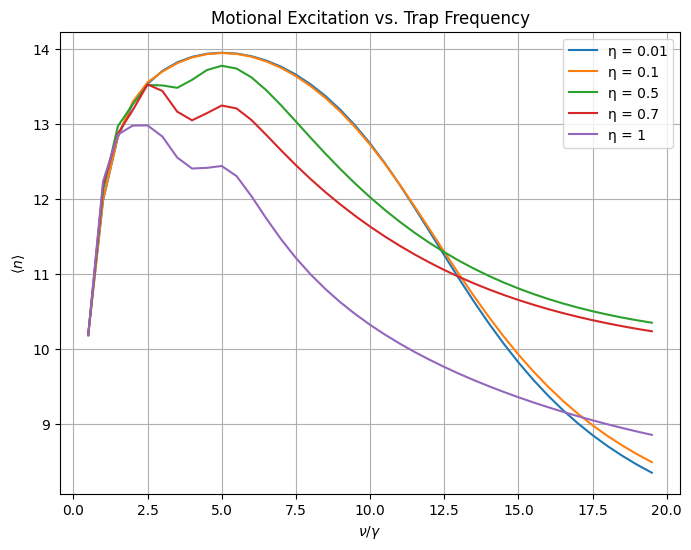

In [115]:
plt.figure(figsize=(8, 6))
for j, eta in enumerate(eta_values):
    plt.plot(nu_values / Gamma, avg_n_eta[:, j], label=f'η = {eta}')

plt.xlabel(r'$\nu / \gamma$')
plt.ylabel(r'$\langle n \rangle$')
plt.title('Motional Excitation vs. Trap Frequency')
plt.legend()
plt.grid()
plt.show()


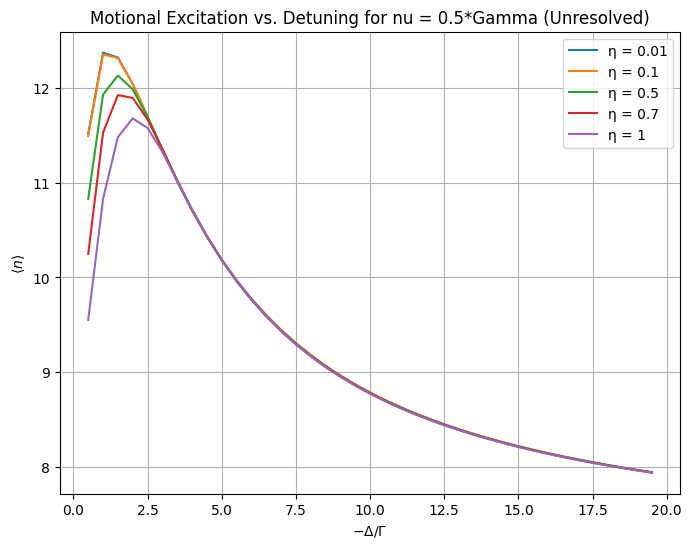

In [111]:
nu = 0.5*Gamma
Delta_values = np.arange(0, 20*Gamma, 0.5*Gamma)[1:]
eta_values = [0.01,0.1,0.5,0.7,1]
avg_n_eta = np.zeros([len(Delta_values), len(eta_values)])
Delta = 0.5 * Gamma
for i, Delta in enumerate(Delta_values):  
    for j, eta in enumerate(eta_values):  
        Omega = eta/Gamma
        ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, -Delta, Gamma, eta)  
        avg_n_eta[i, j] = motional_n_ss  


plt.figure(figsize=(8, 6))
for j, eta in enumerate(eta_values):
    plt.plot(Delta_values / Gamma, avg_n_eta[:, j], label=f'η = {eta}')

plt.xlabel(r'$-\Delta / \Gamma$')
plt.ylabel(r'$\langle n \rangle$')
plt.title('Motional Excitation vs. Detuning for nu = 0.5*Gamma (Unresolved)')
plt.legend()
plt.grid()
plt.show()

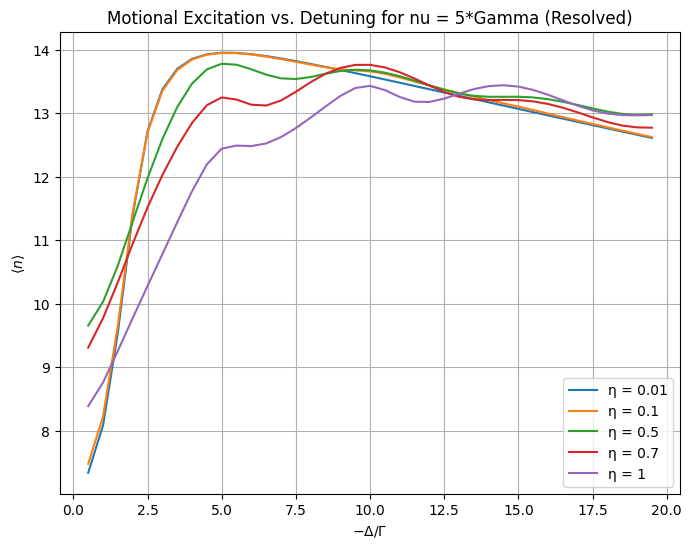

In [112]:
nu = 5*Gamma
Delta_values = np.arange(0, 20*Gamma, 0.5*Gamma)[1:]
eta_values = [0.01,0.1,0.5,0.7,1]
avg_n_eta = np.zeros([len(Delta_values), len(eta_values)])
Delta = 0.5 * Gamma
for i, Delta in enumerate(Delta_values):  
    for j, eta in enumerate(eta_values):  
        Omega = eta/Gamma
        ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, -Delta, Gamma, eta)  
        avg_n_eta[i, j] = motional_n_ss  


plt.figure(figsize=(8, 6))
for j, eta in enumerate(eta_values):
    plt.plot(Delta_values / Gamma, avg_n_eta[:, j], label=f'η = {eta}')

plt.xlabel(r'$-\Delta / \Gamma$')
plt.ylabel(r'$\langle n \rangle$')
plt.title('Motional Excitation vs. Detuning for nu = 5*Gamma (Resolved)')
plt.legend()
plt.grid()
plt.show()

In [67]:
# Initial state: excited internal state and motional ground state
psi0 = qt.tensor(qt.basis(2, 1), qt.basis(n_motional, 3))

# Time evolution
times = np.linspace(0, 100, 10000)  # Time in microseconds
result = qt.mesolve(H_total, psi0, times, c_ops, [])

# Measurement operators
measure_excited = qt.tensor(excited_proj, id_motional)
measure_ground = qt.tensor(ground_proj, id_motional)
measure_n = qt.tensor(id_internal, a_dag * a)

# Calculate expectation values
excited_pop = qt.expect(measure_excited, result.states)
ground_pop = qt.expect(measure_ground, result.states)
motional_n = qt.expect(measure_n, result.states)

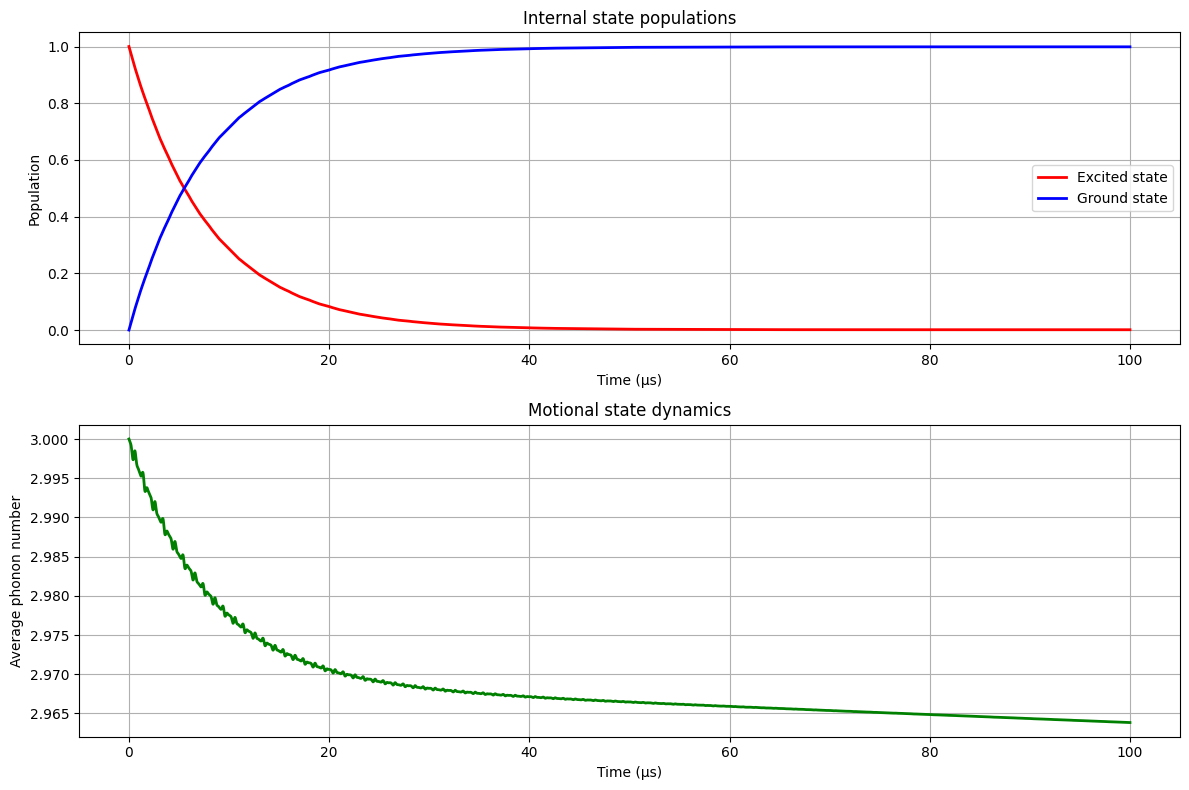

In [68]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot the populations
plt.subplot(2, 1, 1)
plt.plot(times, excited_pop, 'r-', linewidth=2, label='Excited state')
plt.plot(times, ground_pop, 'b-', linewidth=2, label='Ground state')
plt.xlabel('Time (μs)')
plt.ylabel('Population')
plt.title('Internal state populations')
plt.grid(True)
plt.legend()

# Plot the average phonon number
plt.subplot(2, 1, 2)
plt.plot(times, motional_n, 'g-', linewidth=2)
plt.xlabel('Time (μs)')
plt.ylabel('Average phonon number')
plt.title('Motional state dynamics')
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig('quantum_dynamics.png', dpi=300, bbox_inches='tight')

In [ ]:
# from concurrent.futures import ProcessPoolExecutor
# import os  # To get number of CPU cores

# # Constants
# n_motional = 15        # Number of motional levels
# Gamma = 0.01 * 1e6     # Spontaneous emission rate (Γ) in Hz
# eta = 0.05             # Lamb-Dicke parameter

# # Parameter grids
# nu_values = np.arange(0, 1 * Gamma, 0.05 * Gamma)[1:]
# Delta_values = np.arange(0, 1 * Gamma, 0.05 * Gamma)[1:]
# avg_n = np.zeros((len(nu_values), len(Delta_values)))

# # Function to compute steady-state populations
# def compute_avg_n(nu, Delta):
#     ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, Delta, Gamma, eta)
#     return (nu, Delta, motional_n_ss)

# # Get number of available CPU cores and leave one core free
# num_workers = max(1, os.cpu_count() - 1)  # Ensures at least one worker

# # Use multiprocessing to speed up the computation
# with ProcessPoolExecutor(max_workers=num_workers) as executor:
#     results = executor.map(compute_avg_n, 
#                            np.repeat(nu_values, len(Delta_values)), 
#                            np.tile(Delta_values, len(nu_values)))

# # Store results in avg_n array
# for nu, Delta, motional_n_ss in results:
#     i = np.where(nu_values == nu)[0][0]
#     j = np.where(Delta_values == Delta)[0][0]
#     avg_n[i, j] = motional_n_ss

# # Plot the results
# fig, ax = plt.subplots()
# im = ax.imshow(avg_n, 
#                extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
#                        Delta_values[0] / Gamma, Delta_values[-1] / Gamma], 
#                origin="lower",
#                norm=colors.LogNorm(vmin=np.min(avg_n[avg_n > 0]), vmax=np.max(avg_n)), 
#                cmap="jet")

# # Colorbar
# cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
# cbar.set_label(r'$ \langle n \rangle $')

# # Labels and title
# ax.set_xlabel(r'$\nu / \Gamma$')
# ax.set_ylabel(r'$\Delta / \Gamma$ (red-detuned)')
# ax.set_title("Unresolved Sideband Regime")

# # Text labels
# ax.text(0.8, -0.1, r'$\eta=0.05$', fontsize=12, color='black')

# plt.show()


In [ ]:
# import cupy as cp  # GPU-accelerated version of NumPy


# # Constants
# n_motional = 15
# Gamma = 0.01 * 1e6
# eta = 0.05

# # Convert values to CuPy arrays (GPU)
# nu_values = cp.array(np.arange(0, 1 * Gamma, 0.05 * Gamma)[1:])
# Delta_values = cp.array(np.arange(0, 1 * Gamma, 0.05 * Gamma)[1:])
# avg_n = cp.zeros((len(nu_values), len(Delta_values)))

# # Function to compute steady-state populations using CuPy
# def compute_avg_n(nu, Delta):
#     ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, Delta, Gamma, eta)
#     return motional_n_ss

# # Vectorized computation using CuPy broadcasting
# nu_grid, Delta_grid = cp.meshgrid(nu_values, Delta_values, indexing="ij")
# avg_n = cp.vectorize(compute_avg_n)(nu_grid, Delta_grid)

# # Convert back to NumPy for plotting
# avg_n = cp.asnumpy(avg_n)
# nu_values = cp.asnumpy(nu_values)
# Delta_values = cp.asnumpy(Delta_values)

# # Plot results
# fig, ax = plt.subplots()
# im = ax.imshow(avg_n, 
#                extent=[nu_values[0] / Gamma, nu_values[-1] / Gamma, 
#                        Delta_values[0] / Gamma, Delta_values[-1] / Gamma], 
#                origin="lower",
#                norm=colors.LogNorm(vmin=np.min(avg_n[avg_n > 0]), vmax=np.max(avg_n)), 
#                cmap="jet")

# # Colorbar
# cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
# cbar.set_label(r'$ \langle n \rangle $')

# # Labels and title
# ax.set_xlabel(r'$\nu / \Gamma$')
# ax.set_ylabel(r'$\Delta / \Gamma$ (red-detuned)')
# ax.set_title("Unresolved Sideband Regime")

# # Text labels
# ax.text(0.8, -0.1, r'$\eta=0.05$', fontsize=12, color='black')

# plt.show()
